---
# <div align="center"><font color='green'>  </font></div>
# <div align="center"><font color='green'> COSC 2673/2793 | Machine Learning  </font></div>
## <div align="center"> <font color='green'> Week 11 Lab Exercises: **Feature Selection**</font></div>
---

# Introduction

In this lab you will be:
1. Exploring feature selection methods
2. Exploring feature creation methods

### data set

You will be looking at form the UCI machine learning repository `Breast Cancer Wisconsin (Original) Data Set`. More information on the dataset is at [url](https://archive.ics.uci.edu/ml/datasets/Breast+Cancer+Wisconsin+%28Original%29).
The Breast Cancer Wisconsin (Original) dataset from UCI machine learning repository is a classification dataset, which records the measurements for breast cancer cases. There are two classes, benign and malignant.

You can download this from Canvas.

# Loading the data and EDA

In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
import sklearn as sk

from sklearn import tree
from sklearn import preprocessing
from sklearn import metrics
from sklearn import model_selection

In [2]:
col_names = ['Id_number', 'Clump_Thickness', 'Uniformity_Cell_Size', 
             'Uniformity_Cell_Shape', 'Marginal_Adhesion', 'Epithelial_Cell_Size', 
             'Bare_Nuclei', 'Bland_Chromatin', 'Normal_Nucleoli', 
             'Mitoses', 'Class']
data = pd.read_csv('./breast-cancer-wisconsin.data', names=col_names)

Conduct an EDA and identify the data charactersitics that are important for the task.

# Missing values

Lets see if the data set has any missing values.

In [3]:
data.isnull().sum()

Id_number                 0
Clump_Thickness           0
Uniformity_Cell_Size      0
Uniformity_Cell_Shape     0
Marginal_Adhesion         0
Epithelial_Cell_Size      0
Bare_Nuclei              16
Bland_Chromatin           0
Normal_Nucleoli           0
Mitoses                   0
Class                     0
dtype: int64

Take a closer look at the data set. The column `Bare_Nuclei` contain missing values. In sklearn missing attributes are assumed to be  "NaN" values. These NaN values are problematic, and cannot be used when training a model.

There are two simple methods to handle missing values: 
1. Remove rows (or columns) with NaN values.
2. Replace NaN values with a single temporary value

in pandas you can achieve this by:

In [4]:
data1 = data.dropna()
data2 = data.fillna(value=0)

Try building a simple classifier with both of these data sets. Since this dataset contains relatively low number of missing values you might not see an significant difference. 

<span style="font-size:1.5em;">�</span> **What are the advantages/disadvantages of using both of these methods for handling data sets with missing attributes?** Discuss with your tutor.

It may be desirable to impute for meaningful values for the missing attributes.
The SimpleImputer preprocessor provides an easy interface for this.
The imputer can generate values for NaN values by three methods:

- The mean (average) of all non-missing values for that column
- The median (middle) value of all non-missing values for that column
- The most frequent value of all non-missing values for that column


Below code shows how to apply mean imputation. The imputer class uses the same interface as leaner, that is, to use the imputer requires the `fit()` and `transform()` functions. 

In [5]:
from sklearn.impute import SimpleImputer
imp_mean = SimpleImputer(missing_values=np.nan, strategy='mean')
imp_mean = imp_mean.fit(data)
data = imp_mean.transform(data) # Return a numpy
data = pd.DataFrame(data=data, columns=col_names)

<span style="font-size:1.5em;">�</span> **What are the drawbacks (or problems) of computing the mean over all the training examples?** 

<span style="font-size:1.5em;">�</span> **How can you select the best method for imputation?**

Discuss with your tutor.

# Feature Selection

First lets prepare the attributes and target variable. Note that for the dataset the Class is defines as 2 for benign, 4 for malignant. We can do a simple transform to convert this to 0,1

In [6]:
att_names = col_names[:-1]
Y = (data['Class']-2)/2
X = data.drop(['Class'], axis = 1)

Lets hold out some data to make final judgement. 

In [7]:
from sklearn.model_selection import train_test_split
TrainX, TestX, TrainY, TestY = train_test_split(X, Y, test_size=0.3)

### Using data exploration and expert knowledge about data

When you observe the data you will notice that the column `Id_number` contains no useful information for the task of predicting breast cancer. Therefore it is good practice to drop that column before we proceed. However, as we are interested in learning the concepts of automated feature selection, lets keep it because it will provide us some intuition of the automated feature selection process. At this stage you may also do some feature normalization and other preprocessing tasks you think are appropriate. 

Now lets fit a simple logistic regression model to the data and see how it works. The regularisation parameter `C` is purposefully kept at a very high value to ignore the effect. The cross validation error measures are generated for the comparison between different techniques. 

In [8]:
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import f1_score, accuracy_score
from sklearn.model_selection import cross_val_score

logReg_orig = LogisticRegression(C=10000, max_iter=100, solver='liblinear')
scores = cross_val_score(logReg_orig, TrainX, TrainY, cv=10)
print("Cross Val Accuracy: %0.2f (+/- %0.2f)" % (scores.mean(), scores.std() * 2))

Cross Val Accuracy: 0.67 (+/- 0.01)


## Filter methods
Lets first try a filter method in sklearn. sklearn has many measures inbuilt that can be used to establish the "best" or most important features. 
Two such options are chi-squared and ANOVA F-value measure. Lets first use ANOVA F-value measure to establish the most important features. The number of features to pick is set to 6. 

The SelectKBest class uses the same interface as leaner, that is, to use the SelectKBest requires the `fit()` and `transform()` functions. 

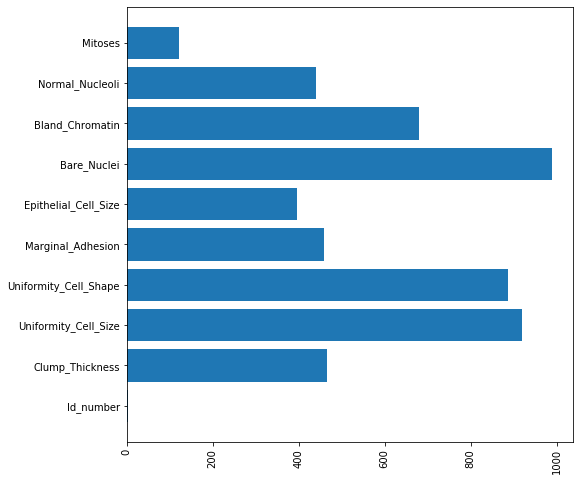

In [9]:
from sklearn.feature_selection import SelectKBest
from sklearn.feature_selection import chi2, f_classif

featureSelector = SelectKBest(score_func=f_classif, k=6).fit(TrainX, TrainY)

# plot the feature importance
plt.figure(figsize=(8,8))
scores = featureSelector.scores_
plt.xticks(rotation='vertical')
plt.barh(att_names, scores, )

# get the selected feature vectors
TrainX_new = featureSelector.transform(TrainX)
TestX_new = featureSelector.transform(TestX)

<span style="font-size:1.5em;">�</span> **What are the most useful features picked by the above measure? How much importance did the measure give to `Id_number`?**

Now you can construct a classifier using the selected "best" 6 features and observe the performance.

<span style="font-size:1.5em;">�</span> **Did you observe any improvements? What can you say about the model complexity and how it may be beneficial in modelling the unknown target function.**

How can you select a good value for k - the number of features to select? You can do this using k-fold cross validation. See what will be the best k for this problem.

In [10]:
# TODO

## Wrapper methods

Wrapper methods measure the performance of a given model on different subsets of features and select the best subset. To make the process computationally tractable some approximation methods are commonly used:

1. Forward selection
2. Backward selection


Lets try recursive feature elimination implemented in sklearn. Note that this method requires a model as input. Again we set the number of features to 6.

In [11]:
from sklearn.feature_selection import RFE
model = LogisticRegression(C=10000, max_iter=100, solver='liblinear')
rfe = RFE(model, 6).fit(TrainX, TrainY)
print("Num Features: %s" % (rfe.n_features_))
sel_inx = np.ix_(rfe.support_)[0].tolist()
print("Selected Features: %s" % [att_names[i] for i in sel_inx])

# get the selected feature vectors
TrainX_new = rfe.transform(TrainX)
TestX_new = rfe.transform(TestX)

Num Features: 6
Selected Features: ['Id_number', 'Uniformity_Cell_Size', 'Uniformity_Cell_Shape', 'Marginal_Adhesion', 'Bare_Nuclei', 'Normal_Nucleoli']


<span style="font-size:1.5em;">�</span> What features did RFE select? where they different to what the filter methods produce? **Do you see a problem with the above implementation?**

We are using the train set to evaluate the performance of each model that may result in over-fitting the feature selection model to train data. Can cross-validation help us here?
Try using the `RFECV` function in sklearn.

Now you can construct a classifier using the selected "best" 6 features and observe the performance.

## Embedded feature selection
We have already used embedded feature selection before: e.g. lasso. Try them for the same problem your self. 

# Feature construction
Feature construction is the process of inventing additional features to add to a learning problem. While this process does not add information, the new features may represent the information is a form that is easier for a leaner to use.

Principal Component Analysis (PCA) is a popular projection method for feature construction
The projection reduces the state space of a set of training data into its `principal components`. 

First lets conduct PCA and see how much variance in data is explained by each of the principle components.

[0.69226403 0.07439376 0.06218771 0.04237246 0.04007939 0.03304748
 0.02331528 0.02182208 0.01051781]


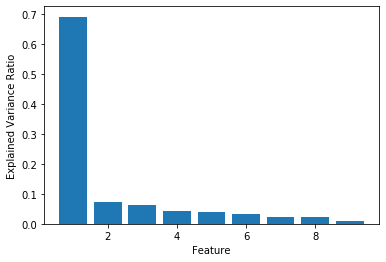

In [12]:
from sklearn.decomposition import PCA
components = 9

TrainX = TrainX.drop(['Id_number'],  axis = 1)


pca = PCA(n_components=components).fit(TrainX)

print(pca.explained_variance_ratio_)
plt.bar(np.arange(1,components+1), pca.explained_variance_ratio_)
plt.ylabel("Explained Variance Ratio")
plt.xlabel("Feature")
plt.show()

Note that here the n_components is set to the number of features in the training dataset as we are interested in observing the explained variance for all the components. <span style="font-size:1.5em;">�</span> How much variance in data is explained by the first two principle components?

Now lets see how we can use PCA to project the data and extract the first two prociple components.

In [13]:
from sklearn.decomposition import PCA
components = 2

TestX = TestX.drop(['Id_number'],  axis = 1)

pca = PCA(n_components=components).fit(TrainX)
TrainX_new = pca.transform(TrainX)
TestX_new = pca.transform(TestX)

Train a model with the new feature representation which only contains 2 features and see what is the performance of the model. 

<span style="font-size:1.5em;">�</span> **Can you use feature selection to select two features that has the same or better performance compared to the PCA model with two features?**

<span style="font-size:1.5em;">�</span> **How can you select the best number of components to be used with PCA?**

Lets observe how good the first principle component is at performing the task (i.e. discriminating between positives and negatives)

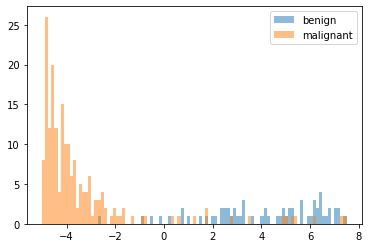

In [14]:
plus = TrainY == 1
X_plus = TrainX_new[plus,0]
X_minus = TrainX_new[~plus,0]

bins = np.linspace(-5, 7.5, 100)

plt.hist(X_plus, bins, alpha=0.5, label='benign')
plt.hist(X_minus, bins, alpha=0.5, label='malignant')
plt.legend(loc='upper right')
plt.show()

<span style="font-size:1.5em;">�</span> **How good is the first principle component in discriminating between positives and negatives?**

You can practice the concepts more using the dataset like [Mammographic Mass Data Set](https://archive.ics.uci.edu/ml/datasets/Mammographic+Mass) in UCI datasets. 